In [1]:
import pandas as pd
from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import regex
from itertools import combinations
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)


In [2]:
data = pd.read_parquet("../results/dhd-corpus.parquet")
data.cities = data.cities.str.split("; ").map(lambda x: [e for e in x if e != ""])
data=data[data.cities.map(lambda x: x!=[])]
data.topics=data.topics.map(lambda x: x.split("; ") if isinstance(x, str) else x)
data.cities.head().to_list()

[['Bochum', 'Berlin'],
 ['Dortmund', 'Berlin', 'Dortmund', 'Dortmund'],
 ['Stuttgart', 'Stuttgart'],
 ['Wien'],
 ['Trier', 'Marbach', 'Halle-Wittenberg']]

### How many publications have at least one author of a specific city?

In [3]:
city_frequency_overall = data.cities.map(lambda x: list(set(x))).explode().value_counts()
city_frequency_overall.to_excel("../results/city_frequency_overall.xlsx")
city_frequency_overall.head(10)

Berlin       155
Wien          89
Würzburg      85
Köln          81
Göttingen     70
Hamburg       68
Stuttgart     62
Graz          62
Leipzig       62
Potsdam       58
Name: cities, dtype: int64

In [4]:
topk_cities = data.cities.map(lambda x: list(set(x))).explode().value_counts().index[:10]

### How many publications have at least one author of a specific city per year?

In [5]:
_tmp = data.copy()
_tmp.cities = _tmp.cities.map(lambda x: list(set(x)))

In [6]:
d = _tmp.groupby("year").cities.apply(lambda x: Counter(sum(x,[]))).unstack()
d.index.name = "Jahr"
d.columns.name = "Stadt"
d

Stadt,Berlin,Bochum,Dortmund,Stuttgart,Wien,Trier,Marbach,Halle-Wittenberg,Gießen,Hamburg,Hannover,Göttingen,Regensburg,Heidelberg,Konstanz,Frankfurt,Karlsruhe,Darmstadt,Salzburg,Potsdam,Tübingen,Bergen,Duisburg,Wolfenbüttel,Braunschweig,Mannheim,Bonn,Erlangen,München,Leipzig,Passau,Hildesheim,Detmold,Essen,Lüneburg,Köln,Dresden,Marburg,Mainz,Bamberg,Freiburg,Magdeburg,Graz,Erfurt,Aachen,Würzburg,Wuppertal,"Delft, Netherlands",Luxembourg,Kassel,Paris,Paderborn,Innsbruck,Cottbus,Jena,Siegen,Krems,Salamanca,Saarbrücken,Kaiserslautern,Zürich,Rostock,Düsseldorf,Basel,Augsburg,Nürnberg,Rom,Beijing,Michigan,Bern,Uppsala,Lausanne,Moskau,Eichstätt,Groningen,Sheffield,Weimar,Cambridge,St. Pölten,Amsterdam,Antwerpen,Klagenfurt,Bielefeld,Melbourne,Washington,Münster,"Hagen, Germany",Verona,Kopenhagen,Lissabon,Bologna,St. Gallen,Le Mans,Oslo,Osnabrück,Illinois,Mailand,Utrecht,Edinburgh,Krakau,Moscow,Milton Keynes,Bremen,Lyon,Greifswald,Jerusalem,Fairfax,Zagreb,Koblenz,Oldenburg,Luzern,London,Athens,Budapest,Kiel,Sakarya,Linköping,Bozen,"Jodhpur, Indien",Oxford Uk,Ormskirk,Santa Barbara,Cork,Glasgow,Frankfurt am Main,Odense
Jahr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,9.0,3.0,1.0,2.0,4.0,7.0,1.0,3.0,3.0,7.0,2.0,5.0,1.0,4.0,1.0,3.0,2.0,4.0,2.0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,9.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,13.0,3.0,1.0,6.0,13.0,4.0,NaN,NaN,1.0,5.0,1.0,6.0,2.0,7.0,NaN,5.0,1.0,2.0,NaN,4.0,4.0,1.0,NaN,3.0,1.0,NaN,3.0,4.0,8.0,9.0,1.0,3.0,2.0,2.0,1.0,4.0,1.0,NaN,1.0,1.0,NaN,1.0,3.0,2.0,NaN,6.0,NaN,NaN,NaN,NaN,1.0,9.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,21.0,NaN,1.0,5.0,11.0,5.0,NaN,3.0,3.0,8.0,1.0,13.0,2.0,4.0,2.0,4.0,1.0,9.0,2.0,5.0,5.0,1.0,1.0,4.0,1.0,4.0,1.0,5.0,7.0,11.0,NaN,1.0,2.0,4.0,NaN,5.0,4.0,3.0,5.0,3.0,2.0,NaN,6.0,NaN,1.0,9.0,NaN,NaN,1.0,1.0,2.0,5.0,2.0,1.0,3.0,2.0,1.0,NaN,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,10.0,1.0,1.0,5.0,9.0,1.0,NaN,1.0,2.0,5.0,NaN,9.0,2.0,NaN,NaN,1.0,3.0,4.0,1.0,5.0,2.0,NaN,NaN,4.0,NaN,2.0,NaN,1.0,3.0,2.0,4.0,NaN,NaN,1.0,NaN,7.0,4.0,2.0,5.0,1.0,NaN,NaN,4.0,NaN,NaN,7.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,2.0,NaN,1.0,1.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,2.0,3.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,20.0,1.0,1.0,11.0,15.0,5.0,1.0,4.0,NaN,7.0,NaN,9.0,4.0,2.0,NaN,5.0,NaN,3.0,NaN,8.0,3.0,NaN,NaN,4.0,NaN,2.0,2.0,5.0,2.0,5.0,5.0,2.0,NaN,1.0,NaN,21.0,6.0,1.0,7.0,3.0,NaN,NaN,8.0,NaN,NaN,15.0,3.0,NaN,1.0,1.0,1.0,3.0,1.0,NaN,2.0,NaN,2.0,NaN,3.0,NaN,3.0,1.0,NaN,4.0,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,14.0,NaN,NaN,6.0,11.0,NaN,NaN,4.0,NaN,10.0,NaN,8.0,3.0,3.0,NaN,9.0,2.0,1.0,NaN,4.0,NaN,NaN,NaN,6.0,NaN,3.0,4.0,4.0,5.0,8.0,2.0,1.0,NaN,NaN,NaN,9.0,1.0,NaN,13.0,NaN,NaN,NaN,6.0,Na

<Axes: xlabel='Jahr', ylabel='Anzahl Publikationen'>

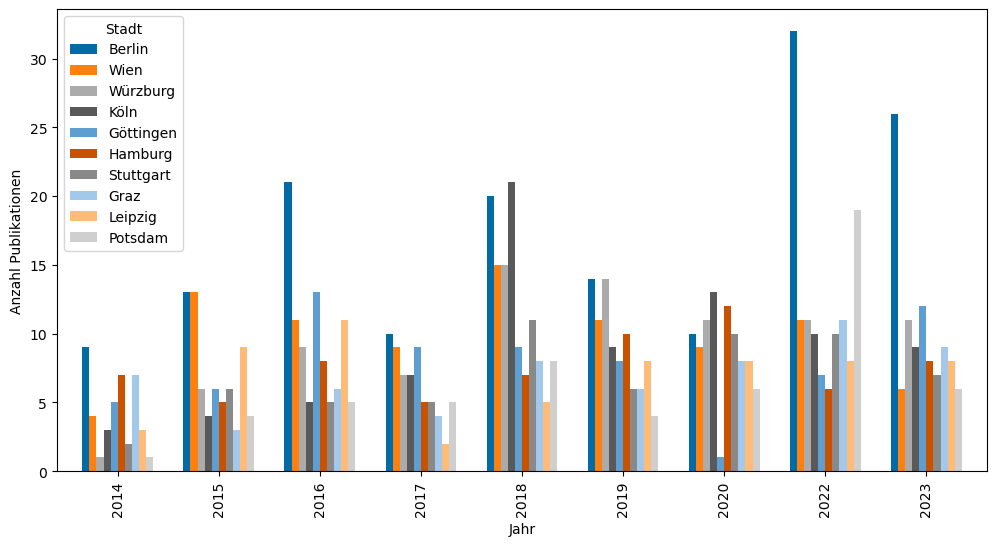

In [7]:
plt.ylabel = "Anzahl Publikationen"
plt.style.use('tableau-colorblind10')
d[topk_cities].plot(kind="bar", figsize=(12,6), ylabel="Anzahl Publikationen", width=0.7)


In [8]:
frequency = _tmp.groupby("year").cities.apply(lambda x: Counter(sum(x,[]))).unstack().fillna(0)
frequency["overall"] = frequency.sum(axis=1)
frequency.to_excel("../results/city-frequencies.xlsx")
frequency

,Berlin,Bochum,Dortmund,Stuttgart,Wien,Trier,Marbach,Halle-Wittenberg,Gießen,Hamburg,Hannover,Göttingen,Regensburg,Heidelberg,Konstanz,Frankfurt,Karlsruhe,Darmstadt,Salzburg,Potsdam,Tübingen,Bergen,Duisburg,Wolfenbüttel,Braunschweig,Mannheim,Bonn,Erlangen,München,Leipzig,Passau,Hildesheim,Detmold,Essen,Lüneburg,Köln,Dresden,Marburg,Mainz,Bamberg,Freiburg,Magdeburg,Graz,Erfurt,Aachen,Würzburg,Wuppertal,"Delft, Netherlands",Luxembourg,Kassel,Paris,Paderborn,Innsbruck,Cottbus,Jena,Siegen,Krems,Salamanca,Saarbrücken,Kaiserslautern,Zürich,Rostock,Düsseldorf,Basel,Augsburg,Nürnberg,Rom,Beijing,Michigan,Bern,Uppsala,Lausanne,Moskau,Eichstätt,Groningen,Sheffield,Weimar,Cambridge,St. Pölten,Amsterdam,Antwerpen,Klagenfurt,Bielefeld,Melbourne,Washington,Münster,"Hagen, Germany",Verona,Kopenhagen,Lissabon,Bologna,St. Gallen,Le Mans,Oslo,Osnabrück,Illinois,Mailand,Utrecht,Edinburgh,Krakau,Moscow,Milton Keynes,Bremen,Lyon,Greifswald,Jerusalem,Fairfax,Zagreb,Koblenz,Oldenburg,Luzern,London,Athens,Budapest,Kiel,Sakarya,Linköping,Bozen,"Jodhpur, Indien",Oxford Uk,Ormskirk,Santa Barbara,Cork,Glasgow,Frankfurt am Main,Odense,overall
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,9.0,3.0,1.0,2.0,4.0,7.0,1.0,3.0,3.0,7.0,2.0,5.0,1.0,4.0,1.0,3.0,2.0,4.0,2.0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,9.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0
2015,13.0,3.0,1.0,6.0,13.0,4.0,0.0,0.0,1.0,5.0,1.0,6.0,2.0,7.0,0.0,5.0,1.0,2.0,0.0,4.0,4.0,1.0,0.0,3.0,1.0,0.0,3.0,4.0,8.0,9.0,1.0,3.0,2.0,2.0,1.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,9.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
2016,21.0,0.0,1.0,5.0,11.0,5.0,0.0,3.0,3.0,8.0,1.0,13.0,2.0,4.0,2.0,4.0,1.0,9.0,2.0,5.0,5.0,1.0,1.0,4.0,1.0,4.0,1.0,5.0,7.0,11.0,0.0,1.0,2.0,4.0,0.0,5.0,4.0,3.0,5.0,3.0,2.0,0.0,6.0,0.0,1.0,9.0,0.0,0.0,1.0,1.0,2.0,5.0,2.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219.0
2017,10.0,1.0,1.0,5.0,9.0,1.0,0.0,1.0,2.0,5.0,0.0,9.0,2.0,0.0,0.0,1.0,3.0,4.0,1.0,5.0,2.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,3.0,2.0,4.0,0.0,0.0,1.0,0.0,7.0,4.0,2.0,5.0,1.0,0.0,0.0,4.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0
2018,20.0,1.0,1.0,11.0,15.0,5.0,1.0,4.0,0.0,7.0,0.0,9.0,4.0,2.0,0.0,5.0,0.0,3.0,0.0,8.0,3.0,0.0,0.0,4.0,0.0,2.0,2.0,5.0,2.0,5.0,5.0,2.0,0.0,1.0,0.0,21.0,6.0,1.0,7.0,3.0,0.0,0.0,8.0,0.0,0.0,15.0,3.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0,3.0,1.0,0.0,4.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239.0
2019,14.0,0.0,0.0,6.0,11.0,0.0,0.0,4.0,0.0,10.0,0.0,8.0,3.0,3.0,0.0,9.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,3.0,4.0,4.0,5.0,8.0,2.0,1.0,0.0,0.0,0.0,9

In [10]:
def _cp(x):
    return sum([list(e for e in combinations(set(city), 2) )  for city in x],[])
pairs = data.groupby(['year']).cities.apply(_cp)
cities = list(set(sum(_tmp.cities, [])))
cocityship = pd.DataFrame(index=cities, columns=cities).fillna(0).astype(int)

for (a1,a2) in sum(pairs,[]):
    cocityship.loc[a1, a2] += 1


## Most Frequent collaborations (At least one author from a city)

In [11]:
c = Counter(tuple(sorted(e)) for e in sum(pairs.to_list(),[]) if e[0] != e[1])
list(sorted(c.items(), key=lambda x: -x[1]))[:10]

[(('Graz', 'Wien'), 17),
 (('Berlin', 'Potsdam'), 13),
 (('Berlin', 'Göttingen'), 11),
 (('Graz', 'Köln'), 9),
 (('Köln', 'Stuttgart'), 9),
 (('Berlin', 'Köln'), 9),
 (('Berlin', 'Mainz'), 9),
 (('Berlin', 'Leipzig'), 8),
 (('Darmstadt', 'Trier'), 7),
 (('Göttingen', 'Wolfenbüttel'), 7)]

In [12]:
G = nx.from_pandas_adjacency(cocityship).to_undirected()
nx.write_gexf(G, "../results/cocityship.gexf")
cocityship.to_excel("../results/cocityship.xlsx")

In [13]:
cocityship.head()

,Nürnberg,Lausanne,Dresden,Innsbruck,Würzburg,Dortmund,Lissabon,Bologna,Bozen,Rom,Mainz,Koblenz,Zagreb,Paderborn,Köln,Odense,Graz,"Delft, Netherlands",Verona,Beijing,Salzburg,Oslo,Hildesheim,Kaiserslautern,Tübingen,Moscow,Paris,Passau,Cambridge,Göttingen,Braunschweig,Gießen,Osnabrück,Santa Barbara,Moskau,Salamanca,Bielefeld,Kopenhagen,Münster,Freiburg,St. Gallen,Fairfax,Krakau,Kiel,Le Mans,Sakarya,Hamburg,Wolfenbüttel,Augsburg,Ormskirk,Stuttgart,Oxford Uk,Lyon,Melbourne,Athens,Eichstätt,Duisburg,Halle-Wittenberg,Saarbrücken,Bonn,London,Uppsala,Krems,Bern,Leipzig,Konstanz,Edinburgh,Groningen,Amsterdam,Wien,München,Cork,Essen,Marbach,Karlsruhe,Rostock,Frankfurt am Main,Weimar,Mailand,Regensburg,Potsdam,Luzern,Glasgow,Luxembourg,Erlangen,Cottbus,Mannheim,Washington,Jerusalem,St. Pölten,Illinois,Darmstadt,Sheffield,Linköping,Erfurt,Bochum,Wuppertal,Magdeburg,Zürich,Basel,Bergen,Lüneburg,Bamberg,Frankfurt,Bremen,Antwerpen,Michigan,Detmold,Milton Keynes,Oldenburg,"Hagen, Germany",Hannover,Greifswald,Berlin,Siegen,Budapest,Klagenfurt,Heidelberg,Düsseldorf,Marburg,Trier,Kassel,Aachen,"Jodhpur, Indien",Jena,Utrecht
Nürnberg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lausanne,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Dresden,0,0,0,1,6,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Innsbruck,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Würzburg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# GeoPandas

In [18]:
import geopandas as gpd#
from geopy import geocoders  
from geodatasets import get_path
from matplotlib import pyplot as plt

#### Connect cities to the topics and present the top 3 keywords for publications with at least on author from a city.

In [19]:
cityfreq = data.cities.map(lambda x: list(set(x))).explode().value_counts().to_frame().reset_index()
_tmp = data[data.topics.map(lambda x: (x is not None) and (x != ['']))].copy()
citytopics = pd.DataFrame(sum(_tmp[["year", "cities", "topics"]].apply(lambda x: [(x["year"],c,t)  for t in x["topics"]  for c in set(x["cities"])] if x["topics"] != []else [] , axis=1),[]),
            columns=["year", "city", "topic"])
city_to_keyword_dict = citytopics.groupby(["city"]).topic.agg(lambda x: ";".join(x.value_counts().index[x.value_counts()>0][:3]))
city_to_keyword_dict = city_to_keyword_dict.to_frame().reset_index()
city_to_keyword_dict
cityfreq.columns = ["city", "count"]
cityfreq = cityfreq.merge(city_to_keyword_dict)
cityfreq.head(10)

,city,count,topic
0,Berlin,155,Annotieren;Visualisierung;Modellierung
1,Wien,89,Annotieren;Modellierung;Daten
2,Würzburg,85,Text;Literatur;Inhaltsanalyse
3,Köln,81,Daten;Modellierung;Visualisierung
4,Göttingen,70,Text;Modellierung;Veröffentlichung
5,Hamburg,68,Annotieren;Text;Visualisierung
6,Stuttgart,62,Literatur;Text;Annotieren
7,Graz,62,Modellierung;Veröffentlichung;Annotieren
8,Leipzig,62,Text;Inhaltsanalyse;Visualisierung
9,Potsdam,58,Visualisierung;Literatur;Text


##### To retrieve the GeoNames make an account here http://www.geonames.org/login
##### https://geocoder.readthedocs.io/providers/GeoNames.html

In [20]:
gn = geocoders.GeoNames("your_user_name")

In [21]:
geocodes = cityfreq.city.map(gn.geocode)

In [22]:
geocodes[geocodes.isna()]

Series([], Name: city, dtype: object)

In [23]:
geocoded_cities = pd.DataFrame([(x[0],x[1][0], x[1][1] ) if x is not None else (None, None, None,) for x in geocodes],
            columns = ["location", "latitude", "longitude"])
df = pd.concat([cityfreq,geocoded_cities], axis=1)
df

,city,count,topic,location,latitude,longitude
0,Berlin,155,Annotieren;Visualisierung;Modellierung,"Berlin, Berlin, Germany",52.52437,13.41053
1,Wien,89,Annotieren;Modellierung;Daten,"Vienna, Vienna, Austria",48.20849,16.37208
2,Würzburg,85,Text;Literatur;Inhaltsanalyse,"Würzburg, Bavaria, Germany",49.79391,9.95121
3,Köln,81,Daten;Modellierung;Visualisierung,"Cologne, North Rhine-Westphalia, Germany",50.93333,6.95000
4,Göttingen,70,Text;Modellierung;Veröffentlichung,"Göttingen, Lower Saxony, Germany",51.53443,9.93228
5,Hamburg,68,Annotieren;Text;Visualisierung,"Hamburg, Hamburg, Germany",53.55073,9.99302
6,Stuttgart,62,Literatur;Text;Annotieren,"Stuttgart, Baden-Wurttemberg, Germany",48.78232,9.17702
7,Graz,62,Modellierung;Veröffentlichung;Annotieren,"Graz, Styria, Austria",47.06667,15.45000
8,Leipzig,62,Text;Inhaltsanalyse;Visualisierung,"Leipzig, Saxony, Germany",51.33962,12.37129
9,Potsdam,58,Visualisierung;Literatur;Text,"Potsdam, Brandenburg, Germany",52.39886,13.06566


In [24]:

gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)
gdf=gdf[~gdf.apply(lambda x: any(e is None for e in x), axis=1)]

In [25]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe =  world[world.name == "europe"]

/tmp/ipykernel_1643288/1223569970.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Interactive Map:
Markersize not proportional !!

In [26]:
gdf["bubble_size"] = gdf["count"].rank() / len(gdf) * 100
gdf.explore("count", tooltip=["city", "count", "topic"], 
            marker_type="circle_marker",
            marker_kwds={"radius":5})

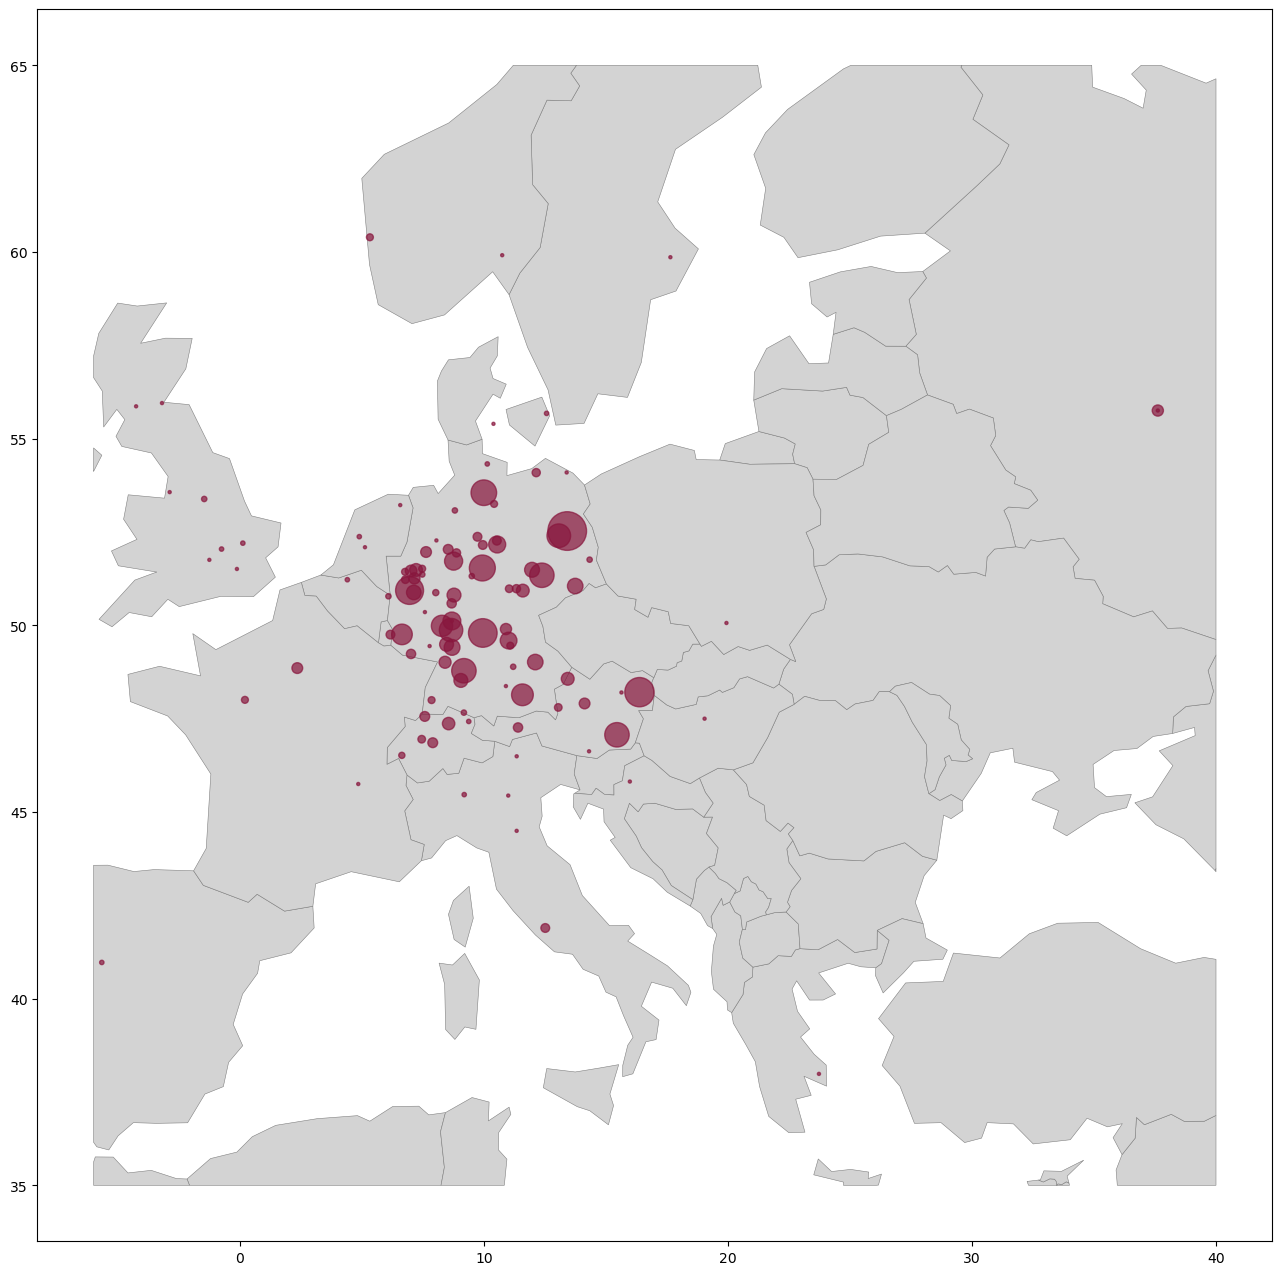

In [27]:
area = [-6, 35,40, 65]
_tmp = gdf.clip(area).copy()

fig, ax = plt.subplots(figsize=(16,16))
marker = _tmp['count']*5

ax = world.clip(area).plot(ax=ax, color="lightgray",edgecolor="grey", linewidth=0.4)
_tmp.plot(ax=ax,color="#88163d", markersize=marker,alpha=0.7, categorical=False,  legend=True )
plt.show()

Download the NUTS_RG_01M_2021_4326.geojson from here [https://gisco-services.ec.europa.eu/features/collections/gisco.nuts_rg_01m_2021_4326.html](https://gisco-services.ec.europa.eu/features/collections/gisco.nuts_rg_01m_2021_4326.html)

In [28]:
import contextily as ctx
europe =  gpd.read_file("NUTS_RG_01M_2021_4326.geojson")

['Österreich', 'Deutschland', 'Luxembourg', 'Schweiz/Suisse/Svizzera']


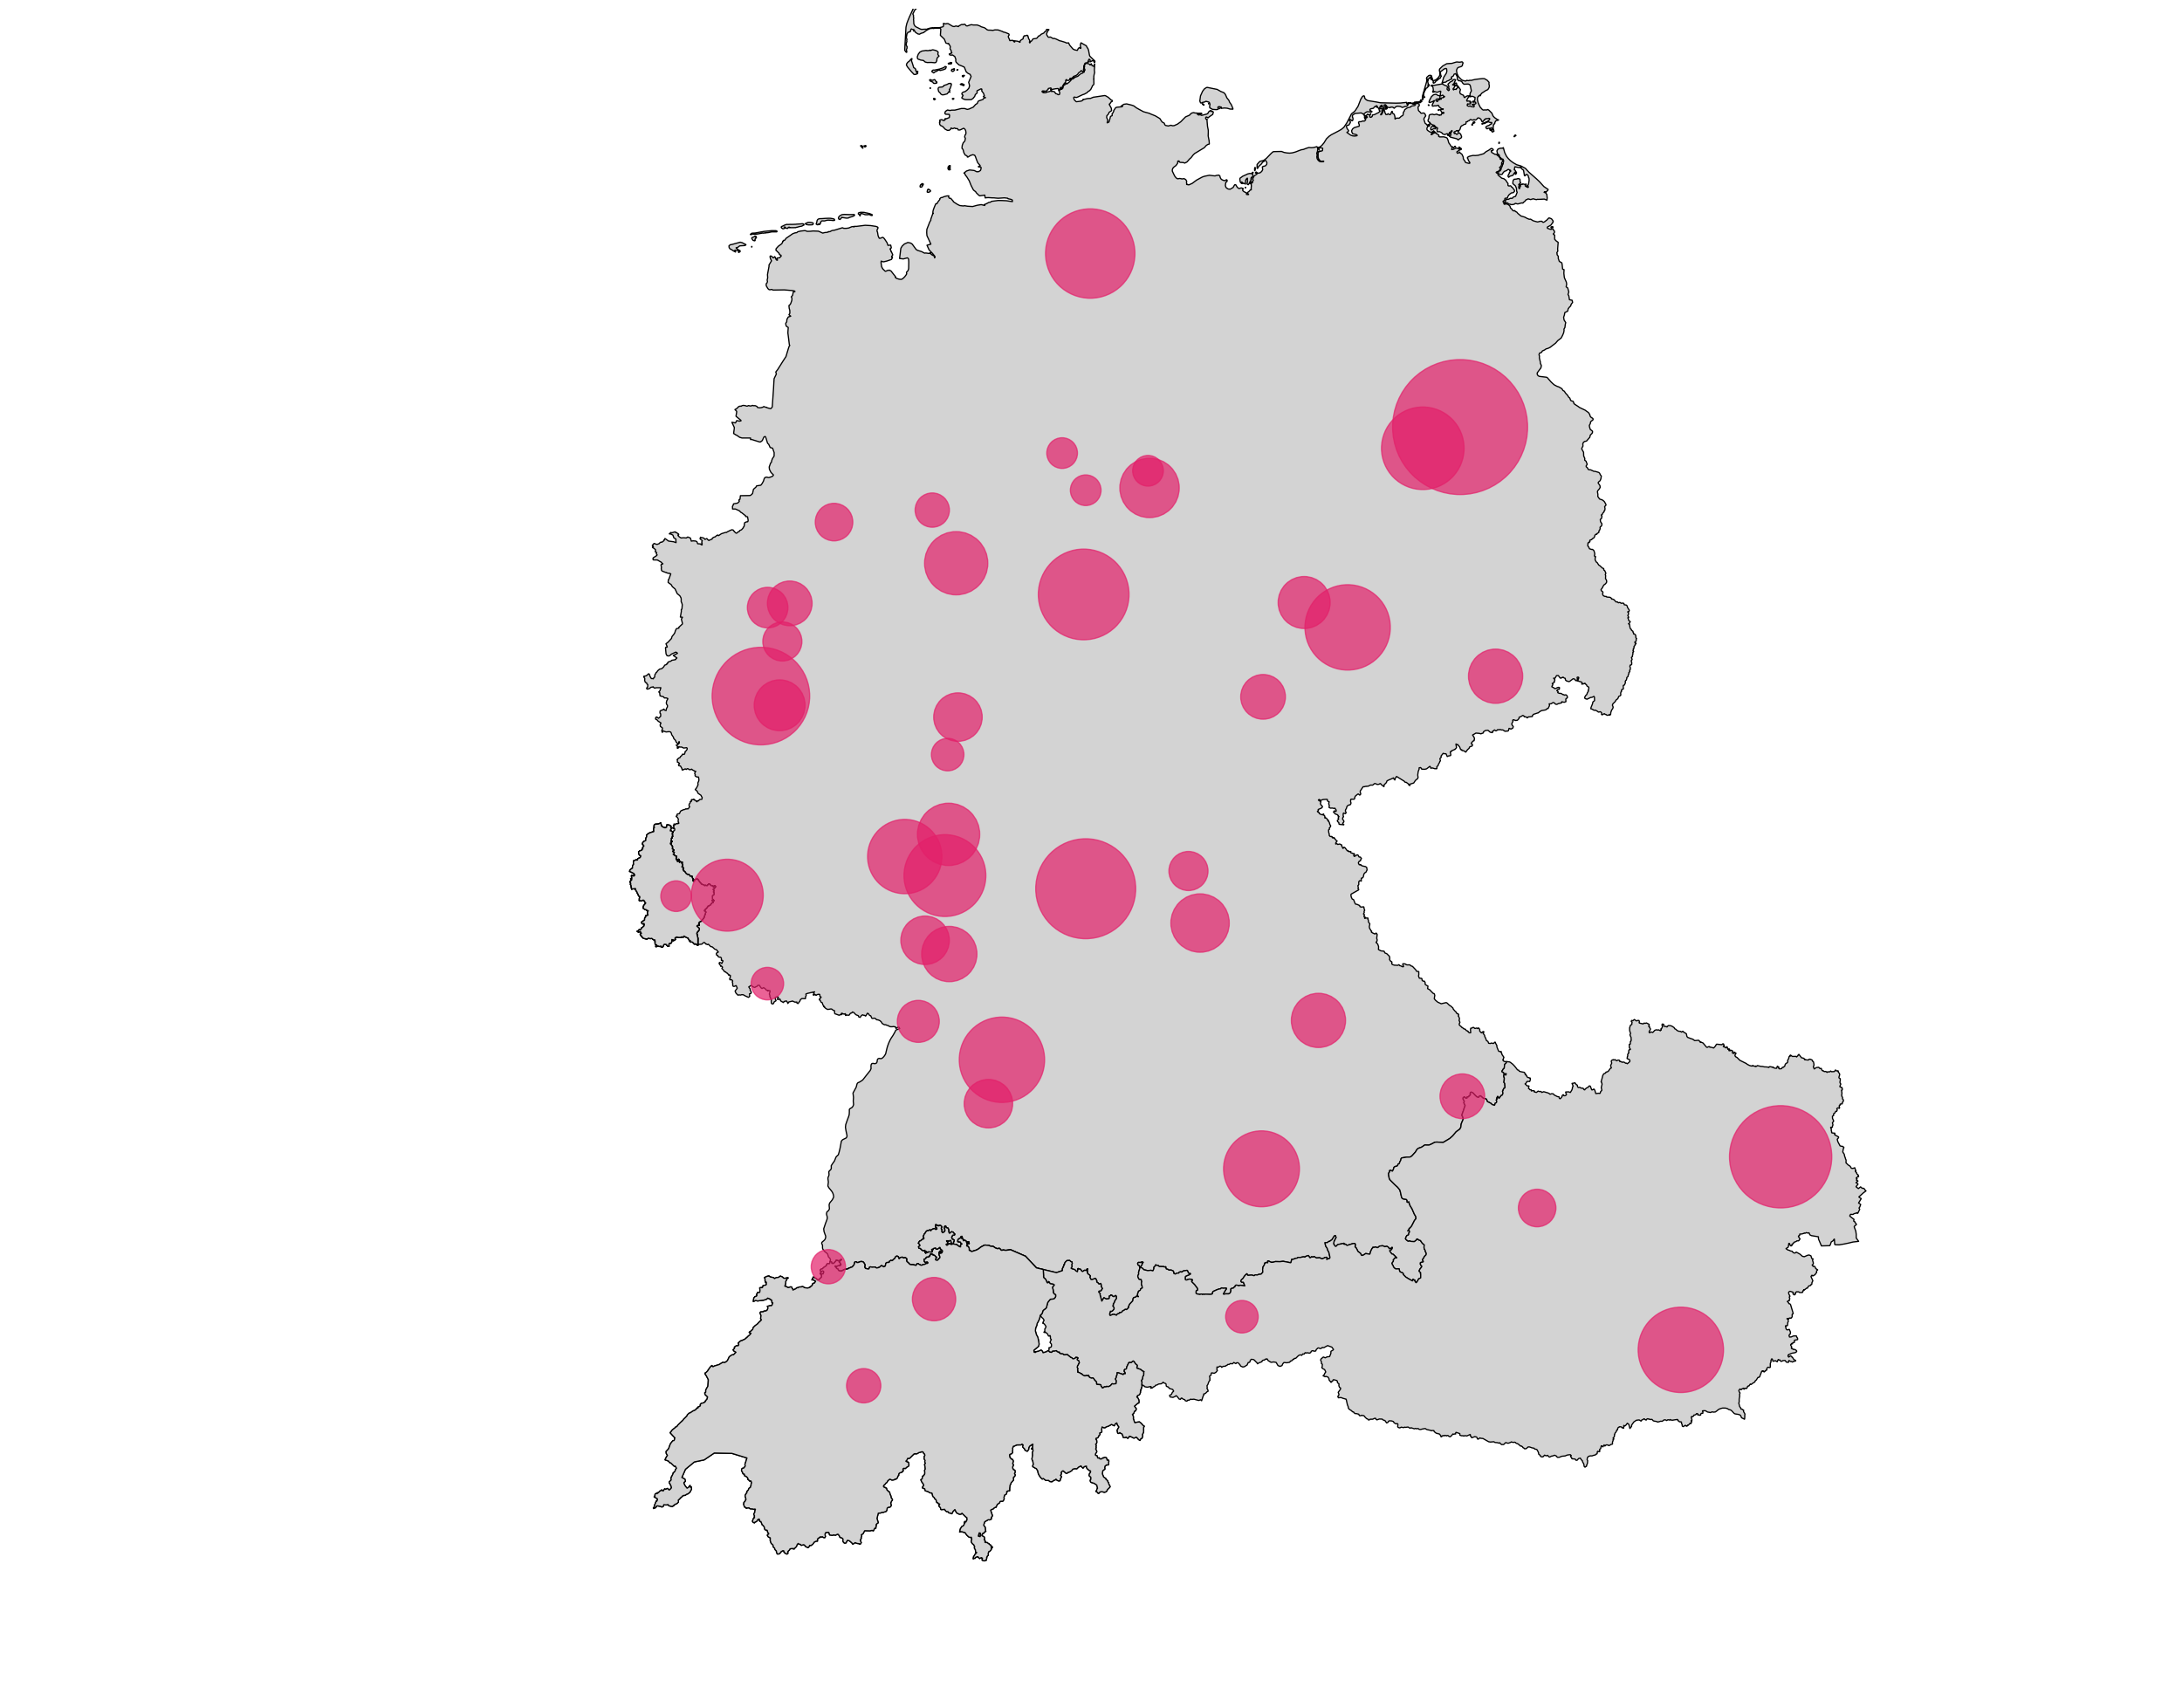

In [29]:
list_of_countries= set(x for x in gdf.location.map(lambda x: x.split(", ")[-1] if x is not None else "") if x != "")
list_of_country_codes=['AT',"DE", "LU", "CH"]
list_of_countries=['Österreich',"Deutschland", "Luxembourg", "Schweiz/Suisse/Svizzera"]

list_of_countriesf=['Austria',"Germany", "Luxembourg", "Switzerland"]
print(list_of_countries)
ax = europe[europe.CNTR_CODE.str.contains("|".join(list_of_country_codes)) & (europe.NUTS_NAME.str.contains("|".join(list_of_countries)))].plot(color="lightgray", figsize=(32,32), edgecolor="black")

_tmp = gdf[gdf.location.map(lambda x: any(l in x for l in list_of_countriesf)) & (gdf["count"]>=8)]
marker = _tmp['count']*80
ax = _tmp.plot(ax=ax,color="#e3206a", markersize=marker,alpha=0.7, categorical=False,  legend=True )
ax.axis([0, 20, 45, 55])
ax.axis("off")
plt.savefig("cityViz.svg")

In [30]:
europe.crs, gdf.crs


(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

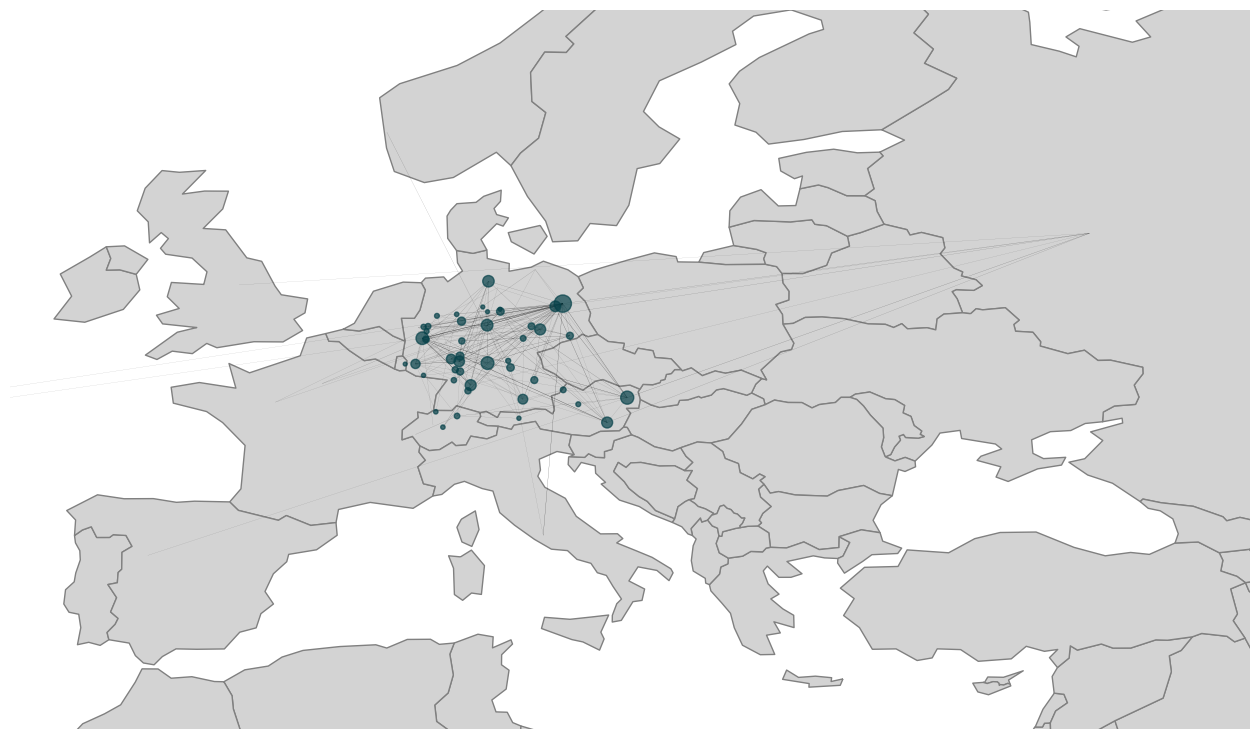

In [34]:
import numpy as np
european_regions = world

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx

sG = nx.Graph([ x for x in G.subgraph(gdf["city"].to_list()).edges(data=True) if x[2]["weight"] >1])
marker = [dict(zip(*_tmp[["city", "count"]].transpose().values)).get(n,0) for n in sG.nodes()]
positions = dict(zip(gdf["city"],gdf["geometry"].map(lambda x: [x.x,x.y])))
ax = european_regions.plot(linewidth=1, edgecolor="grey", facecolor="lightgray", figsize=(16,16))
ax.axis([-12, 45, 33, 66])
ax.axis("off")
nx.draw(sG, positions, ax=ax, node_size=marker, node_color="#07424A", alpha=0.7, width=[x[2]["weight"]/40 for x in sG.edges(data=True)])
plt.show()

In [32]:
gdf.to_file('../results/geodata_publication.geojson')  